<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/densenet121_sequential_0618.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import neccessary packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### 경로 지정&이미지 노이즈

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import os
train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 36179 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


# 모델 불러오기

In [21]:
from tensorflow.keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(64,64,3))
conv_base.trainable = False

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Conv2D(64, 3, activation = 'relu',padding="same")) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation = 'relu',padding="same")) 
#model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(33, activation='softmax'))

conv_base.trainable = False

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 2, 2, 1024)        7037504   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          589888    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 64)          256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 128)         73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 128)        

## 실행

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

my_callbacks=[EarlyStopping(patience=10),
              ModelCheckpoint('model_dense.h5',save_best_only=True),
              ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, min_lr=1e-3)]

Densenet = model.fit_generator(train_generator,
                              steps_per_epoch=556,
                              epochs=50,
                              validation_data=validation_generator,
                              callbacks=my_callbacks)

Epoch 1/50
556/556 [==============================] - 121s 217ms/step - loss: 1.3954 - acc: 0.5837 - val_loss: 1.1154 - val_acc: 0.6404 - lr: 1.0000e-04
Epoch 2/50
556/556 [==============================] - 120s 217ms/step - loss: 1.3288 - acc: 0.5988 - val_loss: 1.0257 - val_acc: 0.6694 - lr: 1.0000e-04
Epoch 3/50
556/556 [==============================] - 118s 213ms/step - loss: 1.2720 - acc: 0.6151 - val_loss: 1.0089 - val_acc: 0.6667 - lr: 1.0000e-04
Epoch 4/50
556/556 [==============================] - 119s 214ms/step - loss: 1.2219 - acc: 0.6314 - val_loss: 0.9100 - val_acc: 0.7062 - lr: 1.0000e-04
Epoch 5/50
556/556 [==============================] - 120s 216ms/step - loss: 1.1856 - acc: 0.6458 - val_loss: 0.8715 - val_acc: 0.7212 - lr: 1.0000e-04
Epoch 6/50
556/556 [==============================] - 119s 214ms/step - loss: 1.1673 - acc: 0.6482 - val_loss: 0.8363 - val_acc: 0.7295 - lr: 1.0000e-04
Epoch 7/50
556/556 [==============================] - 119s 215ms/step - loss: 1.13

In [26]:
model.save('/content/gdrive/My Drive/model_save/densenet/desnet121_sequential_50epoch_0618.h5')

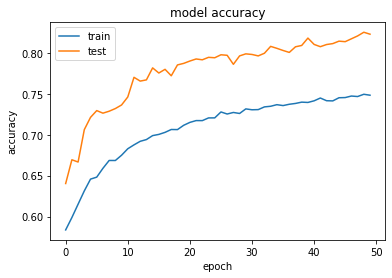

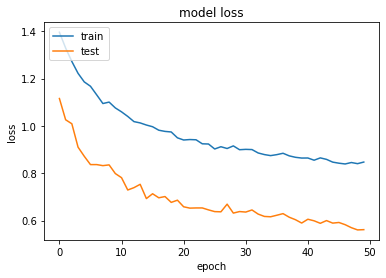

In [29]:
# accuracy plot 
plt.plot(Densenet.history['acc'])
plt.plot(Densenet.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Densenet.history['loss'])
plt.plot(Densenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()